# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
import glob
from nltk.tokenize import word_tokenize
from googletrans import Translator
import matplotlib.pyplot as plt
import emoji

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/dallinmunger/Desktop/USD_Work/ADS 509/Module 1/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data
artists = ['andreabocelli', 'joshgroban']
# Read in the lyrics data

# Create empty lists
songs = []
title = []
artist_name = []
for i in range(len(artists)):
    # Create path to files
    name = data_location + lyrics_folder + artists[i] + '/*.txt'
    # Read in all song files, add to list
    songs.append([open(filename).read() for filename in glob.glob(name)])
    # Extract title from the songs, add to list
    title.append([re.findall(r'"([^"]*)"', i) for i in songs[i]])
    # Create list of artist name
    artist_name.append([artists[i]]*len(songs[i]))
lyrics_df = pd.DataFrame()
title = title[0] + title[1]
lyrics_df['title'] = sum(title, [])
lyrics_df['artist_name'] = artist_name[0] + artist_name[1]
lyrics_df['songs'] = songs[0] + songs[1]

# Translate lyrics
translator = Translator()
lyrics_df['translated_songs'] = [translator.translate(i).text for i in lyrics_df['songs']]

In [5]:
# Read in the twitter data
bocelli_followers = pd.read_csv(data_location + twitter_folder + 'AndreaBocelli_followers_data.txt', sep = '\t')
groban_followers = pd.read_csv(data_location + twitter_folder + 'joshgroban_followers_data.txt', sep = '\t')
# Create twitter df with artist name as one column, descriptions as the other
twitter_df = pd.DataFrame()
twitter_df['artist_name'] = ['andreabocelli']*len(bocelli_followers) + ['joshgroban']*len(groban_followers)
twitter_df['description'] = pd.concat([bocelli_followers['description'], groban_followers['description']], axis=0, ignore_index=True)

In [6]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Read in data, add sentiment and score column - positive
positive = pd.read_csv(positive_words_file, sep = '\t').iloc[33:,].reset_index(drop = True)
positive['sentiment'] = 'positive'
positive['score'] = 1
positive.columns = ['word', 'sentiment', 'score']
# Negative
negative = pd.read_csv(negative_words_file, sep = '\t', encoding='latin-1').iloc[33:,].reset_index(drop = True)
negative['sentiment'] = 'negative'
negative['score'] = -1
negative.columns = ['word', 'sentiment', 'score']
# Tidy text
tidy_text = pd.read_csv(tidy_text_file, sep = '\t')
tidy_text['score'] = np.where(tidy_text['sentiment'] == 'positive', 1, -1)
tidy_text = tidy_text[['word', 'sentiment', 'score']]
# Combine all 3 dataframes
dfs = [positive, negative, tidy_text]
combined_lexicons = pd.concat(dfs).reset_index(drop = True)

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [7]:
def sentiment_score(text):
    sentiment_score = 0
    # Tokenize song
    tokens = word_tokenize(text.lower())
    # Filter through tokens
    for token in tokens:
        # Check if token is in the lexicon
        if combined_lexicons['word'].eq(token).sum() > 0:
            # Save the index
            index = combined_lexicons['word'].eq(token).idxmax()
            # Add the sentiment score at that index to the combined score
            sentiment_score += combined_lexicons['score'][index]
    return sentiment_score/len(tokens)
# Apply sentiment score function to each set of lyrics
lyrics_df['sentiment_score'] = lyrics_df['translated_songs'].apply(sentiment_score)
lyrics_df.head()

,title,artist_name,songs,translated_songs,sentiment_score
0,Vivo Per Lei,andreabocelli,"""Vivo Per Lei""\n\n\n\nVivo per lei da quando s...","""I live for her""\n\n\n\nI live for her since y...",-0.014881
1,E Lucevan Le Stelle,andreabocelli,"""E Lucevan Le Stelle""\n\n\n\nE lucevan le stel...","""And the stars were shining""\n\n\n\nAnd Luceva...",0.041916
2,Vivere,andreabocelli,"""Vivere""\n\n\n\nVivo ricopiando yesterday \ne ...","""To live""\n\n\n\nAlive by copying Yesterday\nA...",0.039394
3,Caruso,andreabocelli,"""Caruso""\n\n\n\nQui dove il mare luccica,\ne t...","""Caruso""\n\n\n\nHere where the sea shines,\nan...",0.035191
4,La Fleur Que Tu M'avais Jetée,andreabocelli,"""La Fleur Que Tu M'avais Jetée""\n\n\n\nLa fleu...","""The flower you threw me""\n\n\n\nThe flower yo...",-0.055901


In [8]:
# Higher average sentiment
print('Average sentiment:')
print(lyrics_df.groupby(['artist_name']).mean())

Average sentiment:
               sentiment_score
artist_name                   
andreabocelli        -0.002694
joshgroban            0.031166


In [9]:
# Highest and lowest sentiment for Andrea Bocelli
print('\nHighest sentiment song (Bocelli):')
bocelli = lyrics_df[lyrics_df['artist_name'] == 'andreabocelli']
print(bocelli[bocelli['sentiment_score'] == bocelli['sentiment_score'].max()][['title', 'sentiment_score']])
print('\nLowest sentiment song (Bocelli):')
print(bocelli[bocelli['sentiment_score'] == bocelli['sentiment_score'].min()][['title', 'sentiment_score']])


Highest sentiment song (Bocelli):
                       title  sentiment_score
17  Il Mare Calmo Della Sera         0.113636

Lowest sentiment song (Bocelli):
              title  sentiment_score
16  Panis Angelicus        -0.142857


In [10]:
# Highest and lowest sentiment for Josh Groban
print('\nHighest sentiment song (Groban):')
groban = lyrics_df[lyrics_df['artist_name'] == 'joshgroban']
print(groban[groban['sentiment_score'] == groban['sentiment_score'].max()][['title', 'sentiment_score']])
print('\nLowest sentiment song (Groban):')
print(groban[groban['sentiment_score'] == groban['sentiment_score'].min()][['title', 'sentiment_score']])


Highest sentiment song (Groban):
                          title  sentiment_score
23  Jesu, Joy Of Man's Desiring         0.224138

Lowest sentiment song (Groban):
                                  title  sentiment_score
32  Let Me Fall (From Cirque Du Soleil)        -0.065868


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Josh Groban does, with an average sentiment of 0.031166 compared to Andre Bocelli's average sentiment of -0.002699.

---

Q: For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: The songs are printed above. (Highest: Il Mare Calmo Della Sera, Lowest: Panis Angelicus)

---

Q: For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: The songs are printed above. (Highest: Jesu, Joy of Man's Desiring, Lowest: Let Me Fall (From Cirque Du Soleil))

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




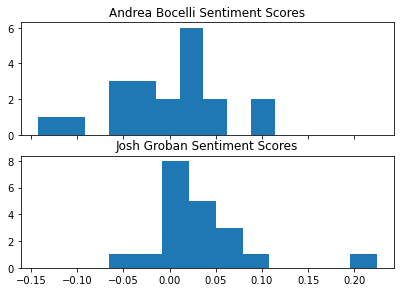

In [11]:
# Plot distribution of sentiment scores
fig, ax = plt.subplots(2, 1, sharex = True)
fig.tight_layout()
ax[0].hist(bocelli['sentiment_score'])
ax[0].set_title('Andrea Bocelli Sentiment Scores')
ax[1].hist(groban['sentiment_score'])
ax[1].set_title('Josh Groban Sentiment Scores')
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. 

In [12]:
# Positive emoji list
positive_emojis = [':two_hearts:', ':red_heart:', ':thumbs_up:', ':sparkling_heart:', ':blue_heart:',
                  ':beaming_face_with_smiling_eyes:', ':slightly_smiling_face:', ':grinning_face_with_smiling_eyes:', 
                  ':grinning_face_with_big_eyes:', ':grinning_face:', ':grinning_face_with_sweat:', ':revolving_hearts:',
                  ':smiling_face_with_heart-eyes:', ':face_with_tears_of_joy:', ':folded_hands:']
positive_emojis = [emoji.emojize(i) for i in positive_emojis]
positive_emojis = pd.DataFrame({'emojis':positive_emojis, 'sentiment':[1 for i in range(15)]})

# Negative emoji list
negative_emojis = [':pensive_face:', ':flushed_face:', ':confused_face:', ':worried_face:', ':slightly_frowning_face:',
                  ':frowning_face:', ':crying_face:', ':loudly_crying_face:', ':pouting_face:', ':angry_face:',
                  ':clown_face:', ':unamused_face:', ':lying_face:', ':grimacing_face:', ':nauseated_face:']
negative_emojis = [emoji.emojize(i) for i in negative_emojis]
negative_emojis = pd.DataFrame({'emojis':negative_emojis, 'sentiment':[-1 for i in range(15)]})

# Combine positive and negative into one df
emojis_lexicon = pd.concat([positive_emojis, negative_emojis], ignore_index=True)

# Create sentiment column
def sentiment_score(text):
    sentiment_score = 0
    # Tokenize song
    tokens = word_tokenize(text.lower())
    tokens = sum([emoji.get_emoji_regexp().split(i) for i in tokens],[])
    # Filter through tokens
    for token in tokens:
        # Check if token is in the lexicon
        if emojis_lexicon['emojis'].eq(token).sum() > 0:
            # Save the index
            index = emojis_lexicon['emojis'].eq(token).idxmax()
            # Add the sentiment score at that index to the combined score
            sentiment_score += emojis_lexicon['sentiment'][index]
    return sentiment_score/len(tokens)


twitter_df['description'] = twitter_df['description'].fillna('na')
twitter_df['sentiment_score'] = twitter_df['description'].apply(sentiment_score)
twitter_df.head

<bound method NDFrame.head of         artist_name                                        description  \
0     andreabocelli                                                 na   
1     andreabocelli  #Ateísmo. #Ciência. #Tecnologia. #Administraçã...   
2     andreabocelli                              Let your dreams alive   
3     andreabocelli  My wife,traveling, BBQ, and astronomy are my p...   
4     andreabocelli                                                 na   
...             ...                                                ...   
9995     joshgroban                                             😍😍❤❤😘😘   
9996     joshgroban                                                 na   
9997     joshgroban                                                 na   
9998     joshgroban  Irlande 🇮🇪☘️🦢 | Maï ♡ | @vincentniclo ☆ | @col...   
9999     joshgroban  Stumbling along through life; loves the earth ...   

      sentiment_score  
0            0.000000  
1            0.000000  
2        

In [13]:
# Higher average sentiment
print('Average sentiment:')
print(twitter_df.groupby(['artist_name']).mean())

Average sentiment:
               sentiment_score
artist_name                   
andreabocelli         0.003861
joshgroban            0.002491


In [14]:
# Tokenize the descriptions
tokenized_description = []
for text in twitter_df['description']:
    tokens = word_tokenize(text.lower())
    tokens = sum([emoji.get_emoji_regexp().split(i) for i in tokens],[])
    tokenized_description.append(tokens)
twitter_df['tokenized_description'] = tokenized_description

# Split the dataframe by artist
bocelli = twitter_df[twitter_df['artist_name'] == 'andreabocelli']
groban = twitter_df[twitter_df['artist_name'] == 'joshgroban']

# Make the tokenized description one long list
bocelli_tokens = bocelli['tokenized_description'].sum()
groban_tokens = groban['tokenized_description'].sum()

# Count number of times the positive and negative emojis occur
# Positive and negative emojis for Andrea Bocelli
def count_emojis(df, tokens_data):
    counter = Counter()
    for word in tokens_data:
        if word in set(df['emojis']):
            counter[word] += 1
    return counter
print("Positive Andrea Bocelli Emojis:")
print(count_emojis(positive_emojis, bocelli_tokens))
print("\nNegative Andrea Bocelli Emojis:")
print(count_emojis(negative_emojis, bocelli_tokens))

Positive Andrea Bocelli Emojis:
Counter({'❤️': 121, '💙': 76, '🙏': 24, '😍': 23, '💕': 19, '💖': 18, '💞': 7, '😂': 6, '😃': 5, '🙂': 5, '👍': 5, '😁': 3, '😅': 2, '😀': 2, '😄': 1})

Negative Andrea Bocelli Emojis:
Counter({'😡': 5, '😔': 2, '🙁': 1, '😠': 1})


In [15]:
# Positive and negative emojis for Andrea Bocelli
print("Positive Josh Groban Emojis:")
print(count_emojis(positive_emojis, groban_tokens))
print("\nNegative Josh Groban Emojis:")
print(count_emojis(negative_emojis, groban_tokens))

Positive Josh Groban Emojis:
Counter({'❤️': 110, '💙': 68, '💕': 33, '😍': 29, '🙏': 21, '💖': 15, '😁': 7, '😂': 5, '💞': 4, '🙂': 3, '👍': 3, '😀': 2, '😄': 2, '😃': 2, '😅': 1})

Negative Josh Groban Emojis:
Counter({'😭': 3, '🤢': 1, '😕': 1, '😳': 1, '😔': 1, '🤡': 1, '😒': 1})


Q: What is the average sentiment of your two artists? 

A: Andrea Bocelli has an average sentiment of 0.003861 and Josh Groban has an average sentiment of 0.002491

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: The top positive Andrea Bocelli and Josh emoji is ❤️. The top negative emoji for Andrea Bocelli is 😡 and for Josh Groban it is 😭.

